<a href="https://colab.research.google.com/github/Bhuvanjeet/Point-cloud-classification-with-PointNet/blob/master/point_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Point cloud classification with PointNet**

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds.

**Problem Context:**

A point cloud is a set of data points in space. Point clouds are generally produced by 3D scanners, which measure many points on the external surfaces of objects around them. As the output of 3D scanning processes, point clouds are used for many purposes, including to create 3D CAD (Computer-aided design) models for manufactured parts, for metrology and quality inspection, and for a multitude of visualization, animation, rendering and mass customization applications.

Scene semantic segmentation, which refers to the problem of predicting pixel-wise label for input image. is the process of assigning a label to every pixel in the image. This is in stark contrast to classification, where a single label is assigned to the entire picture. Semantic segmentation treats multiple objects of the same class as a single entity.

Applying deep learning to point clouds for object classification and part/scene semantic segmentation.

**Dataset:**

ModelNet10 model dataset, the smaller 10 class version of the ModelNet40 dataset is used.

"http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"

**This notebook is an implementation of:**

https://keras.io/examples/vision/pointnet/

**Project Overview:**

**1- Exploratory Data Analysis**

**2- Building the PointNet Model**

**3- Training the PointNet Model**

**4- Predictions**

**Exploratory Data Analysis**

In [24]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
import os      #for accessing the directory
import glob    #finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import trimesh   #library for loading and using triangular meshes with an emphasis on watertight surfaces.

In [27]:
#loading the dataset
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [28]:
#trimesh package is used to read and visualize the .off mesh files
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [29]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0010.off"))
mesh.show()


To convert a mesh file to a point cloud we first need to sample points on the mesh surface. .sample() performs a uniform random sampling. Here we sample at 2048 locations and visualize in matplotlib.

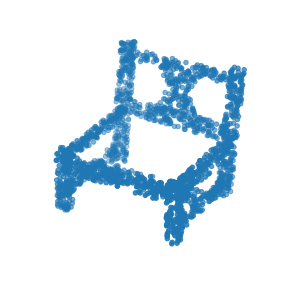

In [30]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

As you will increase the number of points, the lines will become more prominent due to the presence of ore number of points.

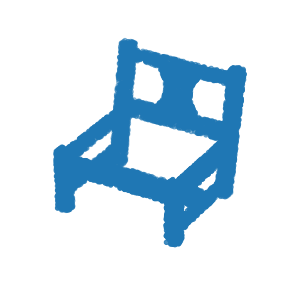

In [31]:
#example
points = mesh.sample(10000)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

To generate a tf.data.Dataset(), we need to first parse through the ModelNet data folders. 

Each mesh is loaded and sampled into a point cloud before being added to a standard python list and converted to a numpy array. 

We also store the current enumerate index value as the object label and use a dictionary to recall this later.

In [32]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [33]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: table
processing class: chair
processing class: bathtub
processing class: toilet
processing class: dresser
processing class: sofa
processing class: night_stand
processing class: desk
processing class: monitor
processing class: bed


Our data can now be read into a tf.data.Dataset() object. We set the shuffle buffer size to the entire size of the dataset as prior to this the data is ordered by class. Data augmentation is important when working with point cloud data. We create a augmentation function to jitter and shuffle the train dataset.

In [34]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

**Building the PointNet model**  

Each convolution and fully-connected layer (with exception for end layers) consits of Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [35]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary Multi-layer Perceptron (MLP) network, and the transformer net (T-net). The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice. The first time to transform the input features (n, 3) into a canonical representation. The second is an affine transformation for alignment in feature space (n, 3). As per the original paper we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [37]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

General Function to build T-net layers



In [40]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

PointNet Model

In [43]:
inputs = tf.keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 2048, 32)     128         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 2048, 32)     128         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 2048, 32)     0           batch_normalization_17[0][0]     
___________________________________________________________________________________________

**Training the PointNet Model**

In [45]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 33s 266ms/step - loss: 3.4332 - sparse_categorical_accuracy: 0.3059 - val_loss: 1889467164184805376.0000 - val_sparse_categorical_accuracy: 0.3855
Epoch 2/20
125/125 [==============================] - 32s 258ms/step - loss: 2.9031 - sparse_categorical_accuracy: 0.4590 - val_loss: 62379.2148 - val_sparse_categorical_accuracy: 0.3756
Epoch 3/20
125/125 [==============================] - 32s 259ms/step - loss: 2.6110 - sparse_categorical_accuracy: 0.5375 - val_loss: 529819.3125 - val_sparse_categorical_accuracy: 0.3976
Epoch 4/20
125/125 [==============================] - 32s 258ms/step - loss: 2.3945 - sparse_categorical_accuracy: 0.6001 - val_loss: 588468256768.0000 - val_sparse_categorical_accuracy: 0.5595
Epoch 5/20
125/125 [==============================] - 32s 259ms/step - loss: 2.2828 - sparse_categorical_accuracy: 0.6364 - val_loss: 1328918.5000 - val_sparse_categorical_accuracy: 0.5529
Epoch 6/20
125/125 [=====================

**Predictions**

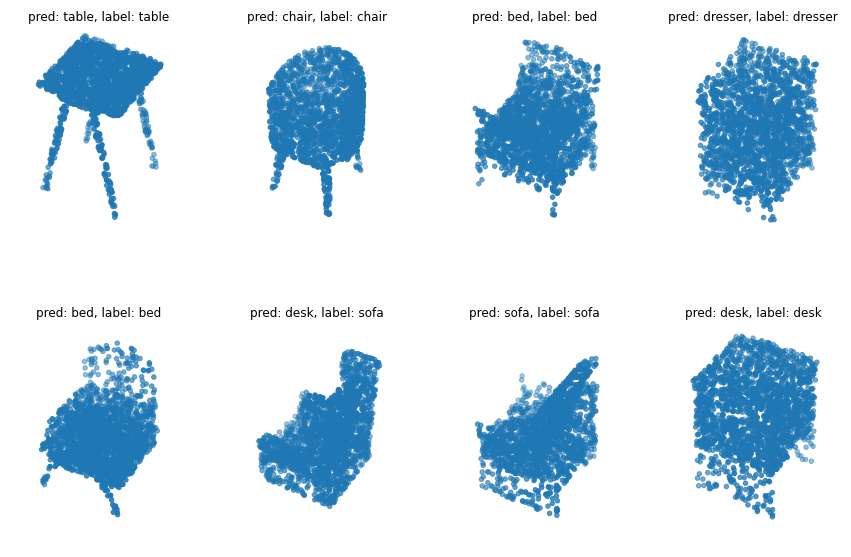

In [46]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()